In [3]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

In [17]:
import zipfile
with zipfile.ZipFile('food_dataset_mini.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [17]:
import json,os
data_folder = './food_dataset_mini'
data = {}

for food_category in os.listdir(data_folder):
    data[food_category] = []
    for food_item in os.listdir(os.path.join(data_folder,food_category)):
        data[food_category].append(food_item)


In [38]:
import shutil

In [18]:
train_split = 0.8
valid_split = 0.1
test_split = 0.1
number_of_test_images = 0

train = {}
valid = {}
test = {}
for category in data:
    size = len(data[category])
    train[category] = []
    valid[category] = []
    test[category] = []
    for i in range(0,int(train_split*size)):
        train[category].append(os.path.join(data_folder,category,data[category][i]))
    for i in range(int(train_split*size),int((train_split + valid_split)*size)):
        valid[category].append(os.path.join(data_folder,category,data[category][i]))
    for i in range(int((train_split + valid_split)*size),int((train_split + valid_split+test_split)*size)):
        test[category].append(os.path.join(data_folder,category,data[category][i]))
        number_of_test_images+=1
# print(len(train),len(valid),len(test))
# print(test)

In [10]:
new_data_folder = './food_dataset_split'

In [41]:
for category in data:
    if not os.path.exists(os.path.join(new_data_folder,'training',category)):
        os.mkdir(os.path.join(new_data_folder,'training',category))
    if not os.path.exists(os.path.join(new_data_folder,'evaluation',category)):
        os.mkdir(os.path.join(new_data_folder,'evaluation',category))
    if not os.path.exists(os.path.join(new_data_folder,'validation',category)):
        os.mkdir(os.path.join(new_data_folder,'validation',category))

    for file in train[category]:
        shutil.copy(file,os.path.join(new_data_folder,'training',category))
    for file in valid[category]:
        shutil.copy(file,os.path.join(new_data_folder,'validation',category))
    for file in test[category]:
        shutil.copy(file,os.path.join(new_data_folder,'evaluation',category))

In [5]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.2,
                    horizontal_flip=True)
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
                    os.path.join(new_data_folder,'training'),
                    target_size = (256,256),
                    batch_size = 32,
                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(
                    os.path.join(new_data_folder,'validation'),
                    target_size = (256,256),
                    batch_size = 32,
                    class_mode='categorical')
test_generator = train_datagen.flow_from_directory(
                    os.path.join(new_data_folder,'evaluation'),
                    target_size = (256,256),
                    batch_size = 32,
                    class_mode='categorical')

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [45]:
# MobileNetV2, ResNet50, VGG16, InceptionResNetV2
basemodel = InceptionResNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

In [33]:
# basemodel.summary()

In [5]:
basemodel.trainable = False

In [6]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name='global_average_pool')(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256,activation='relu',name='dense_1')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128,activation='relu',name='dense_2')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(5,activation='softmax',name='dense_3')(headmodel)

model = Model(inputs=basemodel.input,outputs=headmodel)

In [12]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.01,momentum=0.9),metrics=['accuracy'])

In [13]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [14]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 5, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

2022-02-15 19:06:05.982960: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
125/125 [==============================] - 741s 6s/step - loss: 0.4013 - accuracy: 0.8600 - val_loss: 0.2224 - val_accuracy: 0.9250

Epoch 00001: val_loss improved from inf to 0.22242, saving model to weights.hdf5
Epoch 2/5
125/125 [==============================] - 609s 5s/step - loss: 0.2250 - accuracy: 0.9252 - val_loss: 0.1738 - val_accuracy: 0.9500

Epoch 00002: val_loss improved from 0.22242 to 0.17381, saving model to weights.hdf5
Epoch 3/5
125/125 [==============================] - 608s 5s/step - loss: 0.1917 - accuracy: 0.9392 - val_loss: 0.1357 - val_accuracy: 0.9604

Epoch 00003: val_loss improved from 0.17381 to 0.13570, saving model to weights.hdf5
Epoch 4/5
125/125 [==============================] - 606s 5s/step - loss: 0.1751 - accuracy: 0.9427 - val_loss: 0.1862 - val_accuracy: 0.9333

Epoch 00004: val_loss did not improve from 0.13570
Epoch 5/5
125/125 [==============================] - 607s 5s/step - loss: 0.1633 - accuracy: 0.9480 - val_loss: 0.1803 - val_a

In [19]:
# Evaluate the performance of the model
t1 = time.time()
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)
t2 = time.time()
print('Accuracy Test : {}'.format(evaluate[1]))
print(f'Total Prediction Time: {t2-t1}')
print(f'Prediction Time per Image: {(t2-t1)/number_of_test_images}')

15/15 [==============================] - 66s 4s/step - loss: 0.1411 - accuracy: 0.9479
Accuracy Test : 0.9479166865348816
Total Prediction Time: 82.48504710197449
Prediction Time per Image: 0.16497009420394898


In [23]:
print("number of test images: " + str(number_of_test_images))

number of test images: 500


In [15]:
labels = ['chicken_wings','chocolate_cake','dumplings','french_fries','guacamole']

In [20]:
# loading images and their predictions 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2
prediction = []
original = []
image = []
count = 0
for i in os.listdir(os.path.join(new_data_folder,'evaluation')):
  for item in os.listdir(os.path.join(os.path.join(new_data_folder,'evaluation'),i)):
    #code to open the image
    img= PIL.Image.open(os.path.join(os.path.join(new_data_folder,'evaluation'),i,item))
    #resizing the image to (256,256)
    img = img.resize((256,256))
    #appending image to the image list
    image.append(img)
    #converting image to array
    img = np.asarray(img, dtype= np.float32)
    #normalizing the image
    img = img / 255
    #reshaping the image in to a 4D array
    img = img.reshape(-1,256,256,3)
    #making prediction of the model
    predict = model.predict(img)
    #getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #appending the predicted class to the list
    prediction.append(labels[predict])
    #appending original class to the list
    original.append(i)


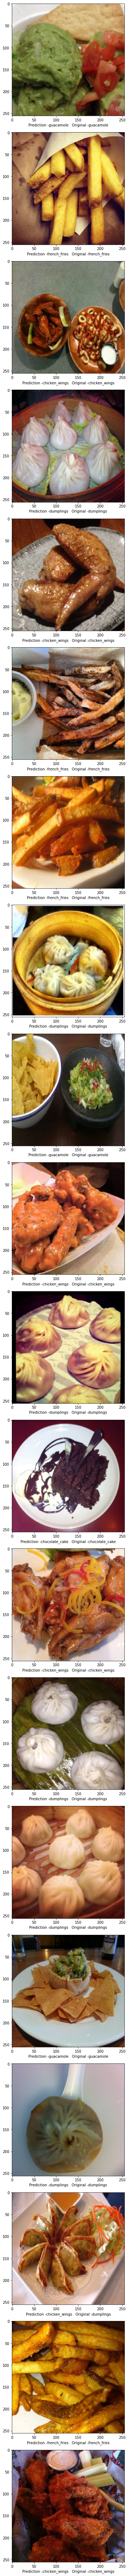

In [40]:
# visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Confusion_matrix')

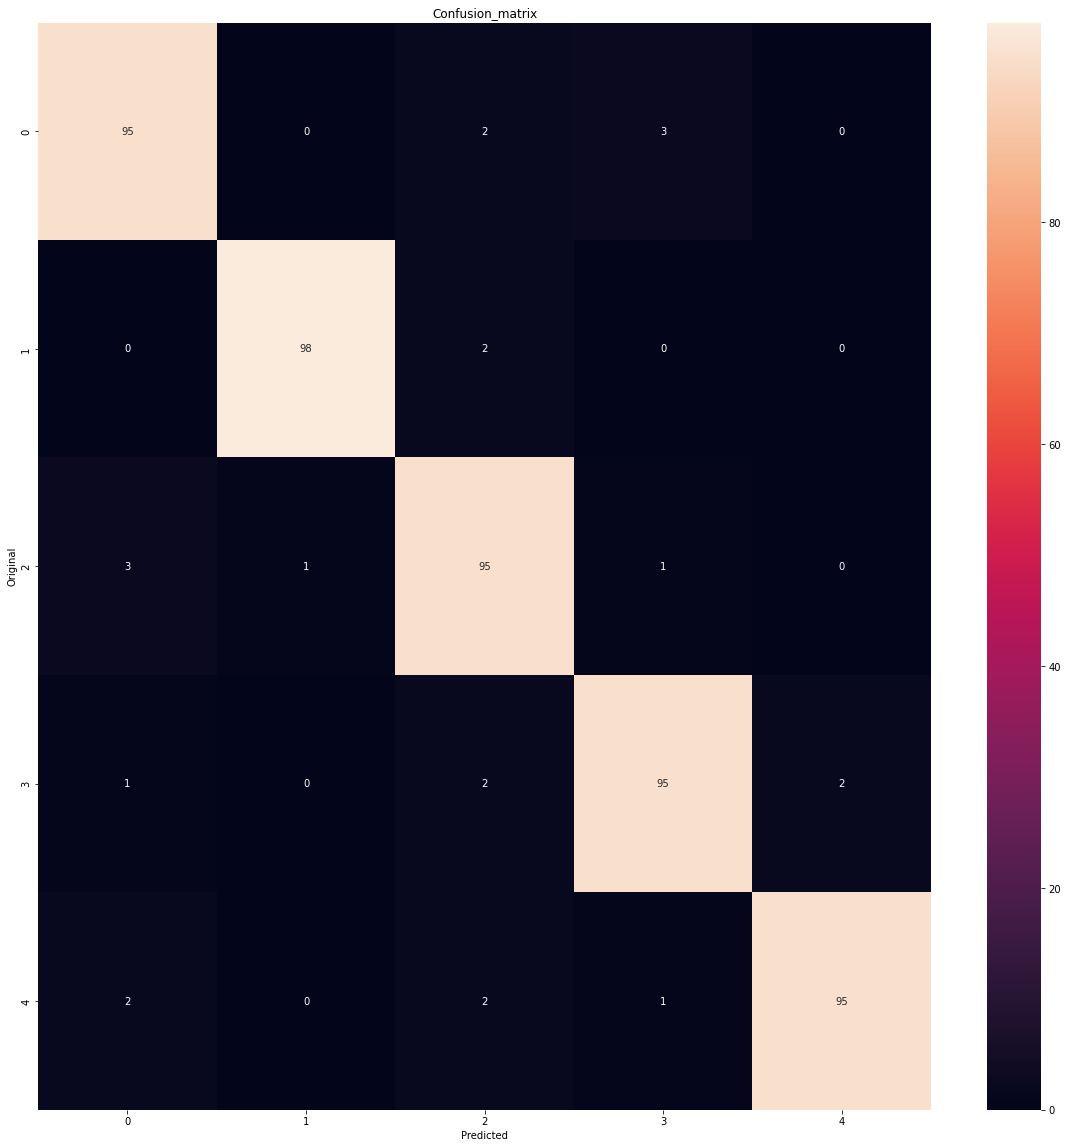

In [22]:
plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [31]:
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic -y